# Setup

In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from utils import get_wiki_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load GPT2 model fine-tuned on writing prompts

gpt2_modelfile = 'gpt2-xl'
model_args = ModelArguments(
    model_name_or_path=gpt2_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')

# compute_metrics = get_compute_metrics_func(experiment_id="jupyter_ipynb", metric_names=['accuracy', 'mauve'])

In [4]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [5]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [77]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.txt'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/greedy.csv"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5.csv"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_p_0.9.csv"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_k_30.csv"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/typical_p_0.95.csv"
gpt2_entropy_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eag_5_1.5.csv"
gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5_eab.csv"

In [63]:
NUM_SEQ=1000
MAX_LEN = 128
WIDTH = 5

# Entropy of Human Data

In [40]:
human_dataframe = pd.read_csv(orig_wp, sep='\t', names=['context', 'model_text'], skipinitialspace=True)
# human_dataframe['model_text'] = human_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

In [41]:
human_dataframe.iloc[10].model_text

'The Gales thought well of this established feature. They made it a joyous occasion for themselves as well as their guests. They were hardly an overly wealthy family, and their table was never notable for an oversupply of the good things of life, but whenever they gave a dinner they cast all thoughts of economy to the country winds and worked to the one end that their guests have a pleasant time.\\"'

In [70]:
human_datapoint = human_dataframe.sample().iloc[0]
print(human_datapoint.context)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

Blythe, who according to his own words perceived this as a danger, caught Pořádek's collar, pushed him on the ground, knelt on him and repeatedly told him to stop. He then led the fan by his hair to the edge of the stage, where the fan jumped off. It was only after watching a video of the incident that Blythe found out that a security officer was actually pushing the fan from back. Blythe further said that he saw Pořádek trying to reach the stage yet again before finally being stopped by security. Later, when another fan tried to climb the stage, Blythe thought that it was Pořádek again. Blythe testified that he approached the fan and pushed him with both hands out of the stage in the belief that the crowd would catch him, which it did not. Jiří Choroš, author of video which caught the previous incidents with Pořádek, testified that the fan was for a moment lying on the ground with nobody helping him. Blythe further commented that he saw the fan get up and that other fans showed him th

In [43]:
human_dataframe.iloc[1073].context

"Large flower symbols are set into the sloping talud panels, related to the Venus and star symbols used at Teotihuacan. The roof of the structure was decorated with friezes although only fragments now remain, showing a monstrous face, perhaps that of a jaguar, with another head emerging from the mouth. The second head possesses a bifurcated tongue but is probably not that of a snake. The temple, and its associated ballcourt, probably date to the reign of Nuun Ujol Chaak or that of his son Jasaw Chan K'awiil I, in the later part of the 7th century.Structure 5C-49 possesses a clear Teotihuacan-linked architectural style; it has balustrades, an architectural feature that is very rare in the Maya region, and a talud-tablero façade; it dates to the 4th century AD. It is located near to the Lost World pyramid.Structure 5C-53 is a small Teotihuacan-style platform that dates to about AD 600."

## Compute Average entropy across sequences.

In [66]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

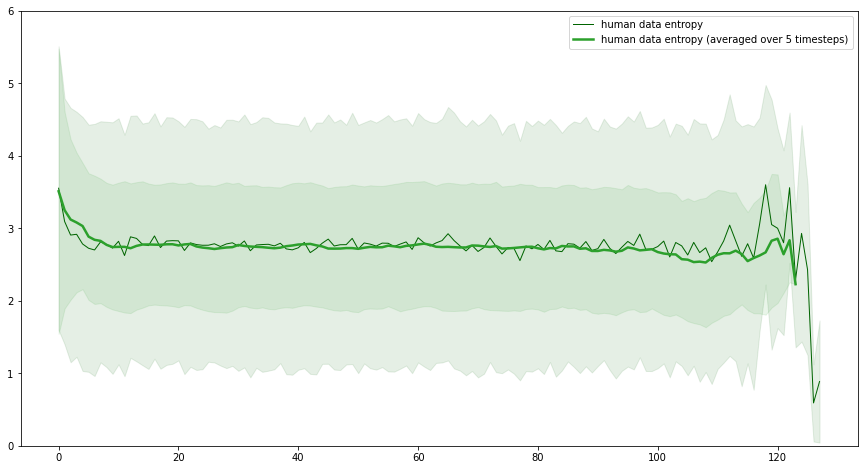

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [73]:

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


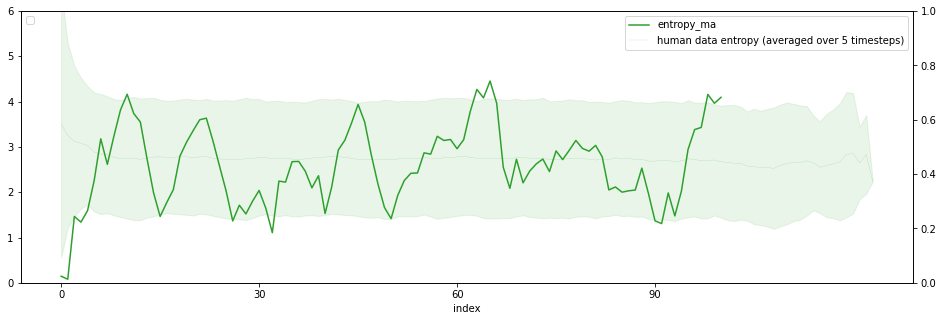

In [74]:
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [136]:
columns = ['context', 'model_text', 'target', 'pct_voilation']
model_greedy_dataframe = pd.read_csv(gpt2_greedy_generation, sep='\t', names=columns, on_bad_lines='skip', usecols=[0,1,2,3])
model_greedy_dataframe.dropna(inplace=True)

model_beam_dataframe = pd.read_csv(gpt2_beam_generation, sep='\t', names=columns, on_bad_lines='skip', usecols=[0,1,2,3])
model_beam_dataframe.dropna(inplace=True)

model_nucleus_dataframe = pd.read_csv(gpt2_nucleus_generation, sep='\t', names=columns, on_bad_lines='skip', usecols=[0,1,2,3])
model_nucleus_dataframe.dropna(inplace=True)

model_topk_dataframe = pd.read_csv(gpt2_topk_generation, sep='\t', names=columns, on_bad_lines='skip', usecols=[0,1,2,3])
model_topk_dataframe.dropna(inplace=True)

model_typical_dataframe = pd.read_csv(gpt2_typical_generation, sep='\t', names=columns, on_bad_lines='skip', usecols=[0,1,2,3])
model_typical_dataframe.dropna(inplace=True)


# model_eag_dataframe = pd.read_csv(gpt2_entropy_greedy_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])


# model_eabs_dataframe = pd.read_csv(gpt2_entropy_beam_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])


In [137]:
model_greedy_dataframe

,context,model_text,target,pct_voilation
0,The Krusty Krab customers are appalled by Spon...,Mr. Krabs then tells them that they will be fi...,"Eventually, Mr. Krabs stops their gibberish ex...",-1
1,"According to Watanabe, the developers asked hi...","Sonic the Hedgehog was a huge success, and the...",This tactic enabled Sega of America to sell 15...,-1
2,Supported by a troop of Matilda tanks from the...,The Japanese counter-attack was fierce and the...,"Engineers were brought forward, as was a bulld...",-1
3,It was produced by Michael G. Wilson and Barba...,Plot [ edit ]<n><n>The film opens with a shot ...,MI6 agent James Bond infiltrates a North Korea...,-1
4,Oxford's crew featured the oldest competitor i...,"The race was won by Oxford's Isis, who won the...",The first Women's Boat Race took place in 1927...,-1
...,...,...,...,...
7695,When the Mongol envoys led by Qidai Tuoyin sho...,The Mongol invasion of China was a disaster. T...,"On 3 March 1273, he sent a 4-member delegation...",-1
7696,The Same Old Story featured guest appearances ...,"I think it's a very good episode, but I don't ...",She stated the two most interesting parts of t...,-1
7697,"The walls remain to gable level, with some tra...","The chancel is a simple, square-built structur...",There are no window openings on the north side...,-1
7698,The team of Angle and Team 3D were the victors...,"The match was won by Storm, who then challenge...",LAX won the restart to retain the championship...,-1


In [141]:
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

print(human_datapoint_idx)

human_datapoint_idx=6

59


In [143]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe[model_greedy_dataframe.context == human_datapoint.context].iloc[0]
beam_sample = model_beam_dataframe[model_beam_dataframe.context == human_datapoint.context].iloc[0]
nucleus_sample = model_nucleus_dataframe[model_nucleus_dataframe.context == human_datapoint.context].iloc[0]
topk_sample = model_topk_dataframe[model_topk_dataframe.context == human_datapoint.context].iloc[0]
typical_sample = model_typical_dataframe[model_typical_dataframe.context == human_datapoint.context].iloc[0]
# eag_sample = model_eag_dataframe.iloc[human_datapoint_idx]
# eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx * 10]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "\\n"))
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text.replace("\n", "\\n"))
print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text.replace("\n", "\\n"))
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text.replace("\n", "\\n"))
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text.replace("\n", "\\n"))
print()

# print("EAG Model Text:")
# print_sample(human_datapoint.context, eag_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EABS Model Text:")
# print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eabs_sample.voilations}")
# print()

Context:
Ward LeRoy Churchill (born 1947) is an American author and political activist. He was a professor of ethnic studies at the University of Colorado Boulder from 1990 until 2007.

Target:
The primary focus of his work is on the historical treatment of political dissenters and Native Americans by the United States government. His work features controversial and provocative views, written in a direct, often confrontational style. In January 2005, Churchill's 2001 essay \"On the Justice of Roosting Chickens\" gained attention.

Greedy Model Text: 
He is the author of several books, including The New Jim Crow: Mass Incarceration in the Age of Colorblindness (2010), The New Jim Crow: Mass Incarceration in the Age of Colorblindness (2010), and The New Jim Crow: Mass Incarceration in the Age of Colorblindness (2010).<n><n>[1] The New Jim Crow, p. xv.<n><n>[2] Ibid., p. xv.<n><n>[3] Ibid., p. xv.<n><n>[4] Ibid., p. xv.<n><n>[5] Ibid., p. x

Beam Model Text: 
He is a member of the Council

<AxesSubplot:xlabel='index'>

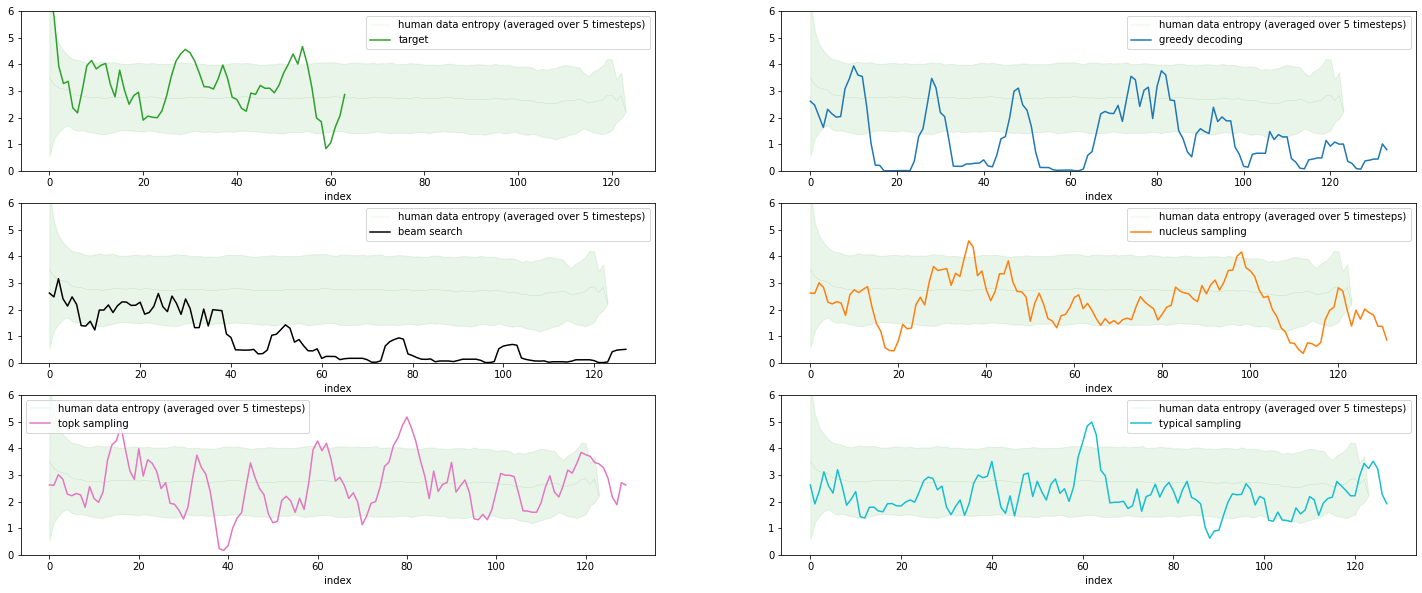

In [144]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

# eag_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eag_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )


# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(3,2, figsize=(25, 10))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')

plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 0], label='beam search', color='black')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling', color='tab:orange')

plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,0], label='topk sampling', color='tab:pink')

plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2,1], label='typical sampling', color='tab:cyan')


# plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
# eag_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2, 0], label='Entropy Aware greedy decoding', color='tab:blue')

# plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
# eabs_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2, 1], label='Entropy Aware greedy decoding', color='tab:olive')



# fig.delaxes(axs[2,1])
# # ax.set_xticklabels(lpdm['token'])
# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Generate using Entropy Aware Greedy Search

In [18]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [145]:
# Greedy
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

In [150]:
# Beam
model_gen_beam_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_beam_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

In [146]:
# Nucleus
model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [147]:
# Topk
model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [148]:
# Typical Decoding
model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps'}, xlabel='Timesteps', ylabel='Average Entropy'>

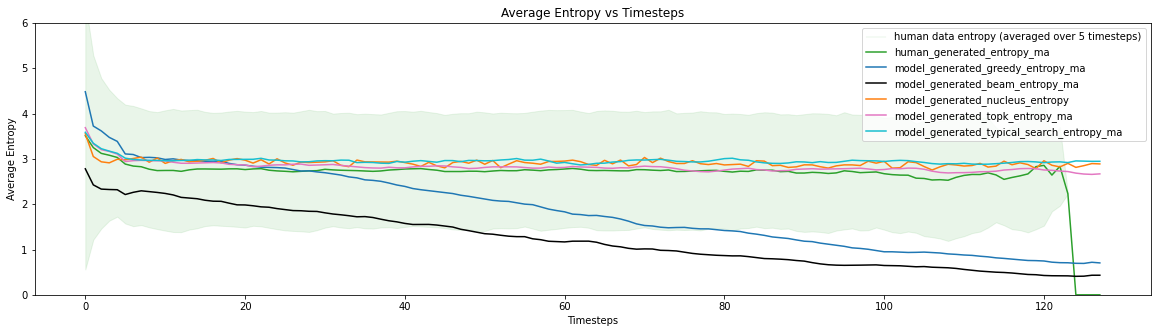

In [152]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd,  model_gen_beam_avg_ma_entropy_pd, model_gen_nucleus_avg_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(20, 5))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Analysis to discover entropy awareness criteria

In [78]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

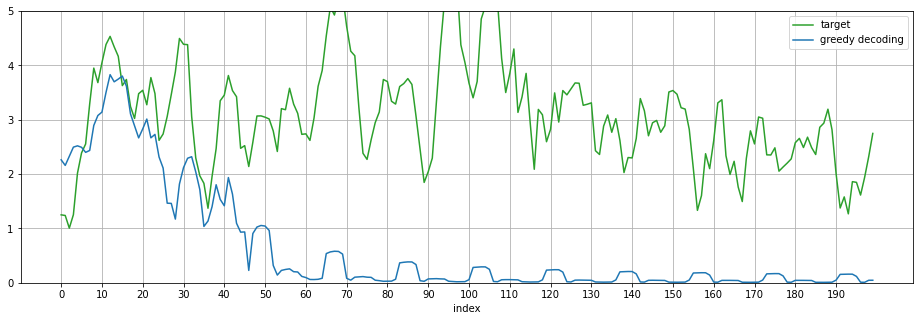

In [79]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [80]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")